In [1]:
from mxnet.gluon import data as gdata
import d2lzh as d2l
from mxnet import nd

In [2]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2

In [3]:
from mxnet import nd

features = nd.random.normal(scale=1, shape=(num_examples, num_inputs))
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += nd.random.normal(scale=0.01, shape=(labels.shape))

In [4]:
features[0], labels[0]

(
 [2.2122064 0.7740038]
 <NDArray 2 @cpu(0)>, 
 [6.000587]
 <NDArray 1 @cpu(0)>)

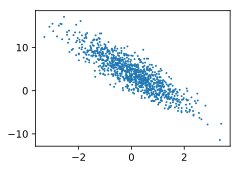

In [5]:
from IPython import display
from matplotlib import pyplot as plt


def use_svg_display():
    display.set_matplotlib_formats('svg')


def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize


set_figsize()
plt.scatter(features[:, 1].asnumpy(), labels.asnumpy(), 1)

In [6]:
# 读取数据
import random


def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = nd.array(indices[i:min(i + batch_size, num_examples)])
        print(features.take(j))
        yield features.take(j), labels.take(j)

In [7]:
def test(n):
    for i in range(n):
        yield i**2


test(10)

for i in test(10):
    print(i)
25

0
1
4
9
16
25
36
49
64
81


25

# MNIST

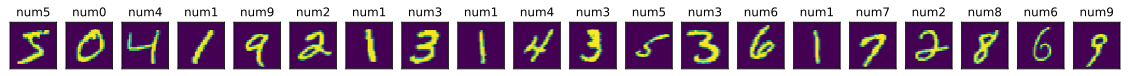

In [8]:
mnist_train = gdata.vision.MNIST(train=True)
mnist_test = gdata.vision.MNIST(train=False)


def get_fashion_mnist_labels(label):
    text_labels = ['num0', 'num1', 'num2', 'num3',
                   'num4', 'num5', 'num6', 'num7', 'num8', 'num9']
    return [text_labels[i] for i in label]


def show_fashion_mnist(images, labels):
    d2l.use_svg_display()
    _, figs = d2l.plt.subplots(1, len(images), figsize=(20, 20))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.reshape((28, 28)).asnumpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)


X, y = mnist_train[0:20]
show_fashion_mnist(X, get_fashion_mnist_labels(y))

# Fashion_MNIST

In [9]:
import sys
import d2lzh as d2l
import time
from mxnet.gluon import data as gdata
%matplotlib inline

In [10]:
mnist_train = gdata.vision.FashionMNIST(train=True)
mnist_test = gdata.vision.FashionMNIST(train=False)

In [11]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [12]:
feature, label = mnist_train[0]

In [13]:
feature.shape, feature.dtype

((28, 28, 1), numpy.uint8)

In [14]:
def get_fashion_mnist_labels(label):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress',
                   'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[i] for i in label]

In [15]:
def show_fashion_mnist(images, labels):
    d2l.use_svg_display()
    _, figs = d2l.plt.subplots(1, len(images), figsize=(20, 20))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.reshape((28, 28)).asnumpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

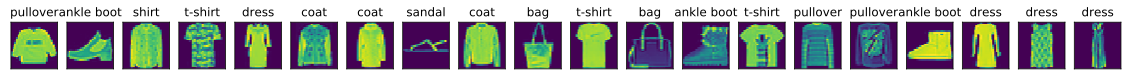

In [16]:
X, y = mnist_train[0:20]
show_fashion_mnist(X, get_fashion_mnist_labels(y))

* 读取小批量

In [17]:
batch_size = 256
transformer = gdata.vision.transforms.ToTensor()
if sys.platform.startswith('win'):
    num_workers = 0
else:
    num_workers = 4

train_iter = gdata.DataLoader(mnist_train.transform_first(
    transformer), batch_size, shuffle=True, num_workers=num_workers)
test_iter = gdata.DataLoader(mnist_test.transform_first(
    transformer), batch_size, shuffle=False, num_workers=num_workers)

# Softmax

## 获取和读取数据

In [18]:
import d2lzh as d2l
from mxnet import autograd, nd

In [19]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 初始化模型参数

In [20]:
num_inputs = 784
num_outputs = 10

W = nd.random.normal(scale=0.01, shape=(num_inputs, num_outputs))
b = nd.zeros(num_outputs)

In [21]:
W.attach_grad()
b.attach_grad()

## 实现Softmax 运算

In [22]:
X = nd.array([[1, 2, 3], [4, 5, 6]])
X.exp()


[[  2.7182817   7.389056   20.085537 ]
 [ 54.59815   148.41316   403.4288   ]]
<NDArray 2x3 @cpu(0)>

In [23]:
X.sum(axis=1, keepdims=True)


[[ 6.]
 [15.]]
<NDArray 2x1 @cpu(0)>

In [24]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(axis=1, keepdims=True)
    return X_exp / partition

In [25]:
X = nd.random.normal(shape=(2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(axis=1, keepdims=True)

(
 [[0.4809104  0.19840434 0.18751799 0.02220035 0.11096693]
  [0.34348798 0.0562974  0.4202956  0.07630844 0.10361061]]
 <NDArray 2x5 @cpu(0)>, 
 [[1.]
  [1.]]
 <NDArray 2x1 @cpu(0)>)

## 定义模型

In [26]:
def net(X):
    return softmax(nd.dot(X.reshape((-1, num_inputs)), W) + b)

## 定义损失函数

In [27]:
def cross_entropy(y_hat, y):
    return -nd.pick(y_hat, y).log()

In [28]:
y_hat = nd.array([[0.1, 0.2, 0.3], [0.4, 0.7, 0.5]])
y = nd.array([2, 1], dtype='int32')
nd.pick(y_hat, y)


[0.3 0.7]
<NDArray 2 @cpu(0)>

## 计算分类准确率

In [29]:
def accuracy(y_hat, y):
    return (y_hat.argmax(axis=1) == y.astype('float32')).mean().asscalar()

In [30]:
accuracy(y_hat, y)

1.0

In [31]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        y = y.astype('float32')
        acc_sum += (net(X).argmax(axis=1) == y).sum().asscalar()
        n += y.size
    return acc_sum / n

In [32]:
evaluate_accuracy(test_iter, net)

0.1571

## 训练模型

In [33]:
num_epochs, lr = 10, .1


def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, trainer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            if trainer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                trainer.step(batch_size)
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d,loss %.4f,train acc %.3f,test acc %.3f' %
              (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

In [34]:
train_ch3(net, train_iter, test_iter, cross_entropy,
          num_epochs, batch_size, [W, b], lr)

epoch 1,loss 0.7897,train acc 0.745,test acc 0.807
epoch 2,loss 0.5735,train acc 0.811,test acc 0.822
epoch 3,loss 0.5287,train acc 0.822,test acc 0.831
epoch 4,loss 0.5049,train acc 0.830,test acc 0.837
epoch 5,loss 0.4895,train acc 0.835,test acc 0.840
epoch 6,loss 0.4787,train acc 0.838,test acc 0.843
epoch 7,loss 0.4687,train acc 0.840,test acc 0.842
epoch 8,loss 0.4629,train acc 0.841,test acc 0.846
epoch 9,loss 0.4551,train acc 0.845,test acc 0.845
epoch 10,loss 0.4516,train acc 0.846,test acc 0.846


## 预测

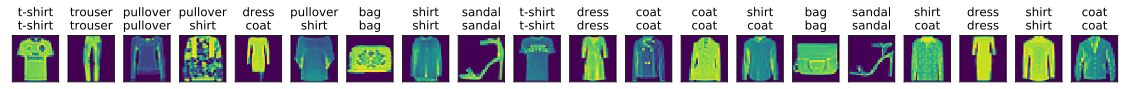

In [35]:
for X, y in test_iter:
    break
true_labels = d2l.get_fashion_mnist_labels(y.asnumpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1).asnumpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]
show_fashion_mnist(X[0:20], titles[0:20])

# 多层感知机

## Relu

In [36]:
from mxnet import nd, autograd
import d2lzh as d2l
%matplotlib inline


def xyplot(x_vals, y_vals, name):
    d2l.set_figsize(figsize=(5, 2.5))
    d2l.plt.plot(x_vals.asnumpy(), y_vals.asnumpy())
    d2l.plt.xlabel('x')
    d2l.plt.ylabel(name + '(x)')

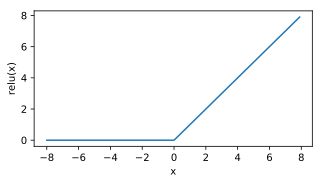

In [37]:
x = nd.arange(-8.0, 8.0, .1)
x.attach_grad()
with autograd.record():
    y = x.relu()
xyplot(x, y, 'relu')

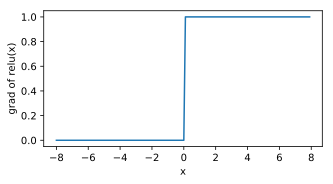

In [38]:
y.backward()
xyplot(x, x.grad, 'grad of relu')

## Sigmoid函数

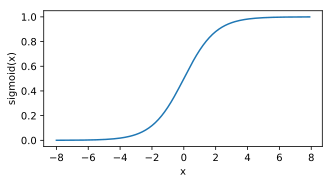

In [39]:
with autograd.record():
    y = x.sigmoid()
xyplot(x, y, 'sigmoid')

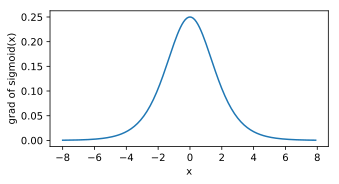

In [40]:
y.backward()
xyplot(x, x.grad, 'grad of sigmoid')

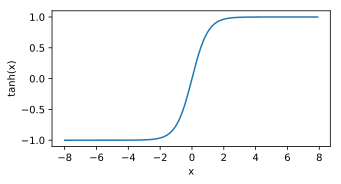

In [41]:
with autograd.record():
    y = x.tanh()
xyplot(x, y, 'tanh')

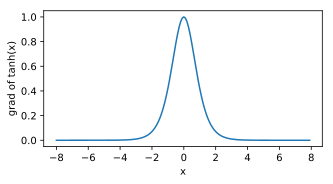

In [42]:
y.backward()
xyplot(x, x.grad, 'grad of tanh')

# 多层感知机从零开始

## 获取和读取数据

In [43]:
from mxnet.gluon import loss as gloss

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 定义模型参数

In [44]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nd.random.normal(scale=0.01, shape=(num_inputs, num_hiddens))
b1 = nd.zeros(num_hiddens)
W2 = nd.random.normal(scale=0.01, shape=(num_hiddens, num_outputs))
b2 = nd.zeros(num_outputs)
params = [W1, b1, W2, b2]

for param in params:
    param.attach_grad()

## 定义激活函数

In [45]:
def relu(X):
    return nd.maximum(X, 0)

## 定义模型

In [46]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(nd.dot(X, W1) + b1)
    return nd.dot(H, W2) + b2

## 定义损失函数

In [47]:
loss = gloss.SoftmaxCrossEntropyLoss()

## 训练模型

In [48]:
num_epochs, lr = 10, 0.5
train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1,loss 0.8156,train acc 0.698,test acc 0.826
epoch 2,loss 0.4895,train acc 0.819,test acc 0.853
epoch 3,loss 0.4287,train acc 0.842,test acc 0.863
epoch 4,loss 0.3958,train acc 0.854,test acc 0.870
epoch 5,loss 0.3785,train acc 0.862,test acc 0.866
epoch 6,loss 0.3574,train acc 0.868,test acc 0.875
epoch 7,loss 0.3415,train acc 0.874,test acc 0.869
epoch 8,loss 0.3327,train acc 0.876,test acc 0.881
epoch 9,loss 0.3209,train acc 0.882,test acc 0.881
epoch 10,loss 0.3097,train acc 0.885,test acc 0.874


# 多层感知机Gluon实现

In [49]:
import d2lzh as d2l
from mxnet.gluon import loss as gloss, nn
from mxnet import gluon, init

## 定义模型

In [50]:
net = nn.Sequential()
net.add(nn.Dense(256, activation='sigmoid'), nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

## 读取数据并训练模型

help(d2l.train_ch3())

In [51]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
loss = gloss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.5})
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss,
              num_epochs, batch_size, None, None, trainer)

epoch 1, loss 1.0512, train acc 0.610, test acc 0.771
epoch 2, loss 0.5788, train acc 0.784, test acc 0.812
epoch 3, loss 0.5084, train acc 0.815, test acc 0.829
epoch 4, loss 0.4728, train acc 0.829, test acc 0.834
epoch 5, loss 0.4461, train acc 0.838, test acc 0.841
epoch 6, loss 0.4311, train acc 0.844, test acc 0.856
epoch 7, loss 0.4145, train acc 0.850, test acc 0.851
epoch 8, loss 0.4015, train acc 0.854, test acc 0.859
epoch 9, loss 0.3904, train acc 0.860, test acc 0.862
epoch 10, loss 0.3850, train acc 0.860, test acc 0.864


In [52]:
def show_fashion_mnist(images, labels):
    d2l.use_svg_display()
    _, figs = d2l.plt.subplots(1, len(images), figsize=(20, 20))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.reshape((28, 28)).asnumpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

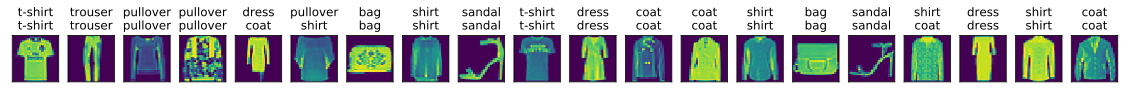

In [53]:
for X, y in test_iter:
    break
true_labels = d2l.get_fashion_mnist_labels(y.asnumpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1).asnumpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]
show_fashion_mnist(X[0:20], titles[0:20])

* numpy.c_

In [54]:
import numpy as np
a = nd.random.normal(shape=(2, 3)).asnumpy()
b = nd.random.normal(shape=(2, 3)).asnumpy()
data = np.c_[a, b]
data.shape

(2, 6)

# 多项式函数拟合实验

In [55]:
from mxnet import nd, gluon
from mxnet.gluon import data as gdata, loss as gloss, nn
import d2lzh as d2l
%matplotlib inline

## 生成数据集

In [56]:
nd.power(nd.array([[2, 1], [3, 4]]), 3)


[[ 8.  1.]
 [27. 64.]]
<NDArray 2x2 @cpu(0)>

In [57]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = nd.random.normal(shape=(n_train + n_test, 1))
poly_features = nd.concat(features, nd.power(
    features, 2), nd.power(features, 3))
labels = (true_w[0] * poly_features[:, 0] + true_w[1] *
          poly_features[:, 1] + true_w[2] * poly_features[:, 2] + true_b)
labels += nd.random.normal(scale=0.1, shape=labels.shape)

In [58]:
features[:2], poly_features[:2], labels[:2]

(
 [[1.2229807 ]
  [0.55320805]]
 <NDArray 2x1 @cpu(0)>, 
 [[1.2229807  1.4956819  1.8291901 ]
  [0.55320805 0.30603915 0.16930333]]
 <NDArray 2x3 @cpu(0)>, 
 [11.595495   5.5548563]
 <NDArray 2 @cpu(0)>)

## 定义、训练和测试模型

In [59]:
from mxnet import autograd

In [60]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [61]:
num_epochs, loss = 100, gloss.L2Loss()


def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': 0.01})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(loss(net(train_features),
                             train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features),
                            test_labels).mean().asscalar())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net[0].weight.data().asnumpy(),
          '\nbias:', net[0].bias.data().asnumpy())

## 三阶多项式函数拟合

final epoch: train loss 0.0050309813 test loss 0.0058998703
weight: [[ 1.192442  -3.395645   5.6030393]] 
bias: [4.9861727]


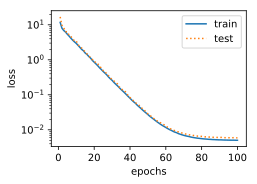

In [62]:
fit_and_plot(poly_features[:n_train, :],
             poly_features[n_train:, :], labels[:n_train], labels[n_train:])

## 线性函数拟合

## 欠拟合

final epoch: train loss 110.03819 test loss 211.54152
weight: [[19.121971]] 
bias: [1.2182939]


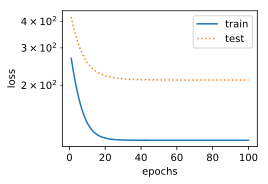

In [63]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:])

## 训练样本不足(过拟合）

final epoch: train loss 0.37301508 test loss 213.42715
weight: [[2.0505433 1.9790244 2.2644174]] 
bias: [2.235838]


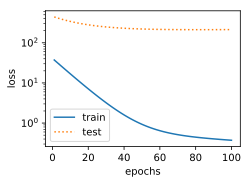

In [64]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
             labels[n_train:])